# Jansky Preprocessing

Script follows the preprocessing workflow provided by the scBestPractices online textbook for processing of scRNAseq datasets for downstream analysis.

Adapted for use on the Jansky NB dataset prior to dataset integration.

### Packages

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import pathlib
import glob
import os
import seaborn as sns
# from rds2py import as_summarized_experiment, read_rds
from matplotlib import pyplot as plt
from scipy.stats import median_abs_deviation

In [4]:
sc.settings.verbosity = 2             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

2024-06-05 12:25:01.811920: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 12:25:03.537001: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


scanpy==1.9.6 anndata==0.10.3 umap==0.5.4 numpy==1.23.4 scipy==1.12.0 pandas==1.5.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.10.8 pynndescent==0.5.11


### Load raw data

In [5]:
# Setting file paths
raw_data = '/project/data/gew123/Raw_h5ad/Jansky_raw.h5ad'
processed_data = '/project/data/gew123/Processed_h5ad/Jansky_processed.h5ad'
figures = '/project/data/gew123/Processed_h5ad/Figures'
dataset = 'Jansky'

In [19]:
# Read in data
adata = sc.read_h5ad(raw_data)

In [12]:
adata

AnnData object with n_obs × n_vars = 64769 × 26344
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'seurat_clusters', 'anno_new', 'CNV', 'celltype', 'patientID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

### Quality Control & Filtering Cells

normalizing counts per cell
    finished (0:00:00)


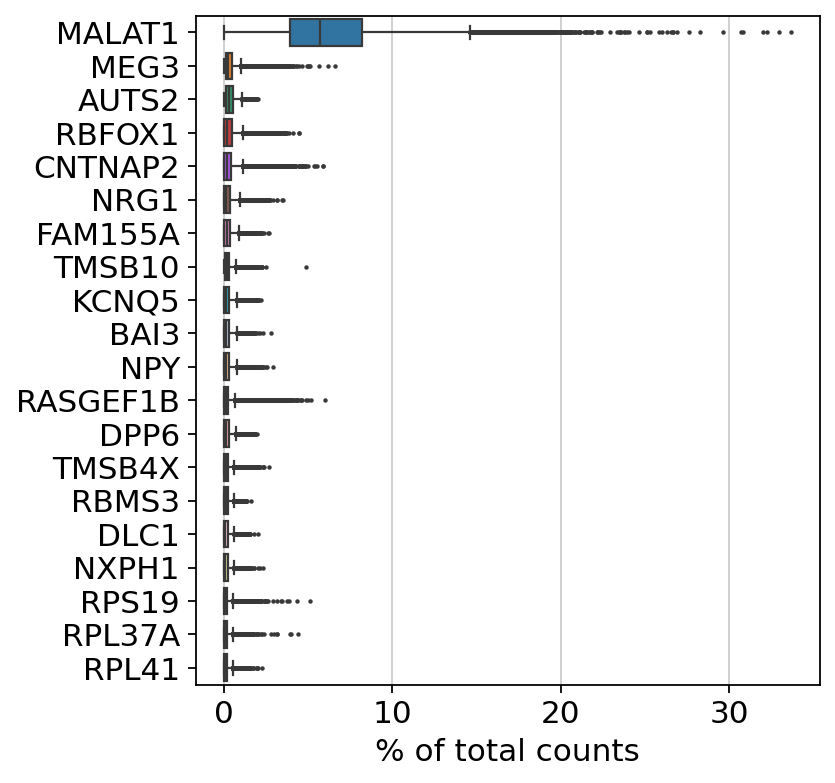

In [14]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [24]:
# Subset mitochondrial genes 
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# Ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# # Hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [25]:
# Filter out by mt, ribo, & hb genes
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)

# Check
adata

AnnData object with n_obs × n_vars = 64769 × 26344
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'seurat_clusters', 'anno_new', 'CNV', 'celltype', 'patientID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [18]:
adata.obs

,nCount_RNA,nFeature_RNA,percent.mt,S.Score,G2M.Score,Phase,seurat_clusters,anno_new,CNV,celltype,...,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,n_genes
AAACCTGAGCAATATG_1,1706,1165,0.000000,0.098487,-0.033414,S,0,Tumor cells,tumor,Tumor cells,...,0,0.000000,0.000000,39,3.688879,2.286049,0,0.000000,0.000000,1165
AAACCTGAGCGCTTAT_1,1225,901,0.163265,-0.107073,-0.133185,G1,2,Tumor cells,non_determined,Tumor cells,...,2,1.098612,0.163265,53,3.988984,4.326531,0,0.000000,0.000000,901
AAACCTGAGGCACATG_1,2027,1414,0.098668,-0.204891,0.073698,G2M,3,Tumor cells,tumor,Tumor cells,...,2,1.098612,0.098668,52,3.970292,2.565368,0,0.000000,0.000000,1414
AAACCTGAGTGGCACA_1,1392,1051,0.143678,0.071120,0.052372,S,2,Tumor cells,tumor,Tumor cells,...,2,1.098612,0.143678,50,3.931826,3.591954,0,0.000000,0.000000,1051
AAACCTGAGTTCGCAT_1,1364,958,0.366569,-0.105258,0.003339,G2M,4,Tumor cells,non_determined,Tumor cells,...,5,1.791759,0.366569,46,3.850148,3.372434,1,0.693147,0.073314,958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCACGATGT_14,417,380,0.479616,-0.059102,0.016418,G2M,1,Tumor cells,non_determined,Tumor cells,...,2,1.098612,0.479616,20,3.044522,4.796163,0,0.000000,0.000000,380
TTTGTCATCAGTGTTG_14,704,612,0.284091,0.058829,0.067365,G2M,1,Tumor cells,tumor,Tumor cells,...,2,1.098612,0.284091,29,3.401197,4.119318,0,0.000000,0.000000,612
TTTGTCATCCACGCAG_14,509,443,0.589391,0.013685,-0.003759,S,1,Tumor cells,non_determined,Tumor cells,...,3,1.386294,0.589391,20,3.044522,3.929273,0,0.000000,0.000000,443
TTTGTCATCCTAGAAC_14,604,519,0.662252,0.051507,0.062610,G2M,2,Tumor cells,tumor,Tumor cells,...,4,1.609438,0.662252,13,2.639057,2.152318,0,0.000000,0.000000,519


/project/soft/linux64/anaconda/Anaconda3-2023.09-0-Linux-x86_64/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


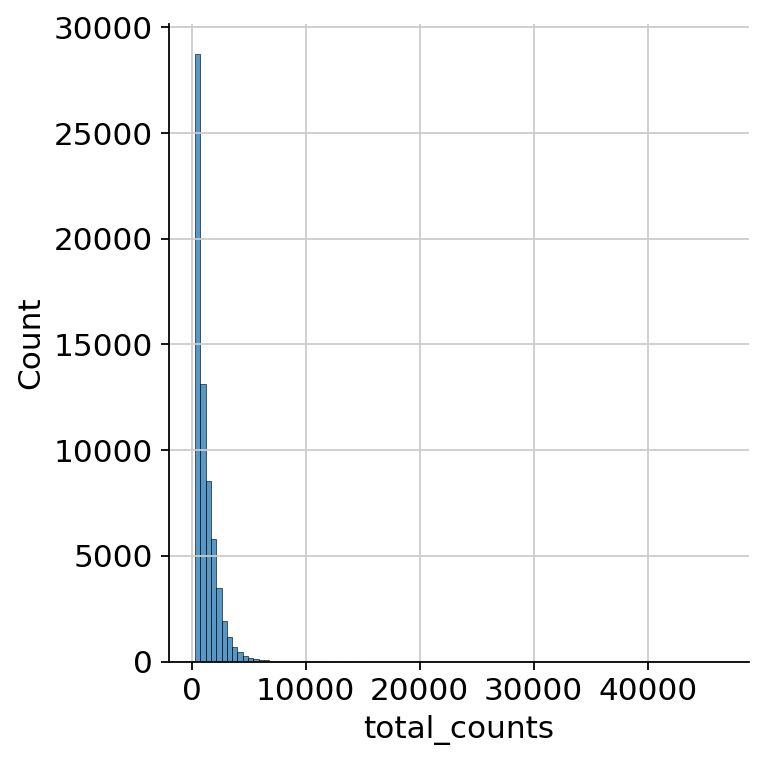

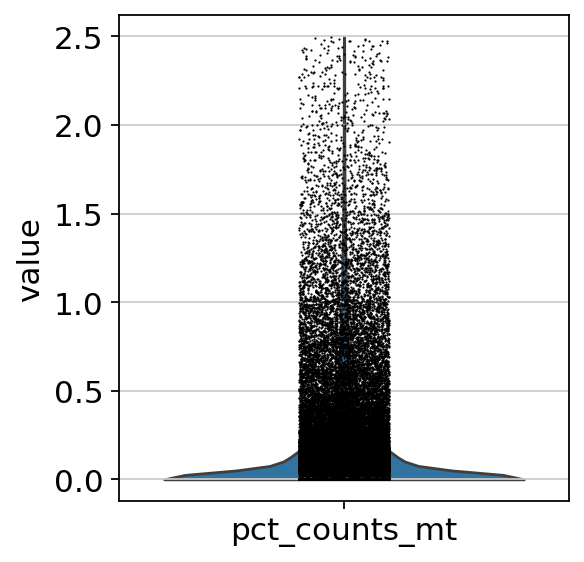

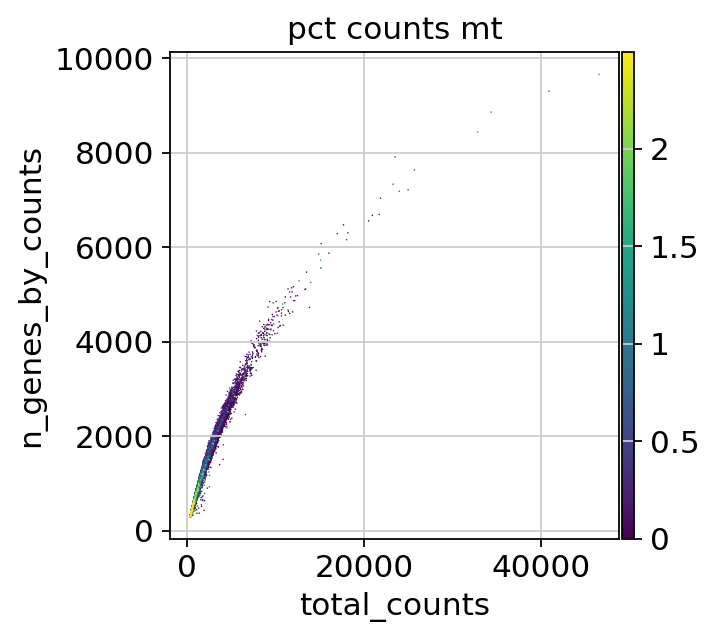

In [27]:
# Plot 3 QC covariates respectively
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", save='_jansky_MT_count.png')

In [9]:
## Automated (performed better than manual):
# Define function to take in filtering metric
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier


# Apply to QC covariates each with a threshold of 5 MADs ### why 5??????? check
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
print("Low quality cells:")
print(adata.obs.outlier.value_counts(), '\n')

# Filter out cells with MT count greater than 8%
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)

print("Cells with high mitochondrial gene expression:")
print(adata.obs.mt_outlier.value_counts())

Low quality cells:
False    64262
True       507
Name: outlier, dtype: int64 

Cells with high mitochondrial gene expression:
False    48658
True     16111
Name: mt_outlier, dtype: int64


In [10]:
# Automated (cont.):
# Filter cells based on low quality / high mit count

print('Filtering cells...\n')
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Filtering cells...

Total number of cells: 64769
Number of cells after filtering of low quality cells: 48237


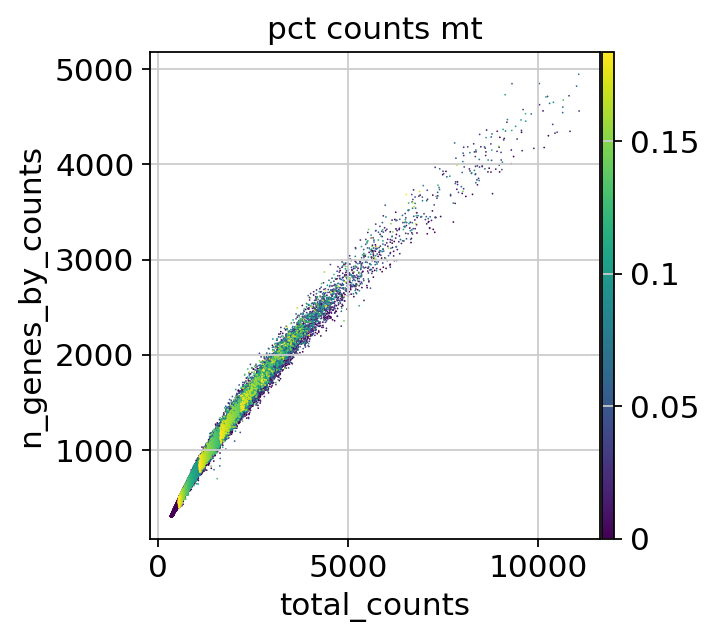

In [12]:
# Plot to confirm sufficient filtering threshold was applied
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", save="_jansky_MT_count.png")

In [28]:
# Also filter out cells with less than 200 genes and genes expressed in less than 3 cells
sc.pp.filter_cells(adata, min_genes=200)
# sc.pp.filter_genes(adata, min_cells=3)

In [17]:
max(adata.obs['total_counts'])

46584

In [16]:
adata

AnnData object with n_obs × n_vars = 64769 × 26344
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'seurat_clusters', 'anno_new', 'CNV', 'celltype', 'patientID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

### Normalization

In [30]:
# Get scaled counts
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)

# Perform transformation
adata.layers["log1p"] = sc.pp.log1p(scales_counts["X"], copy=True)

normalizing counts per cell
    finished (0:00:00)


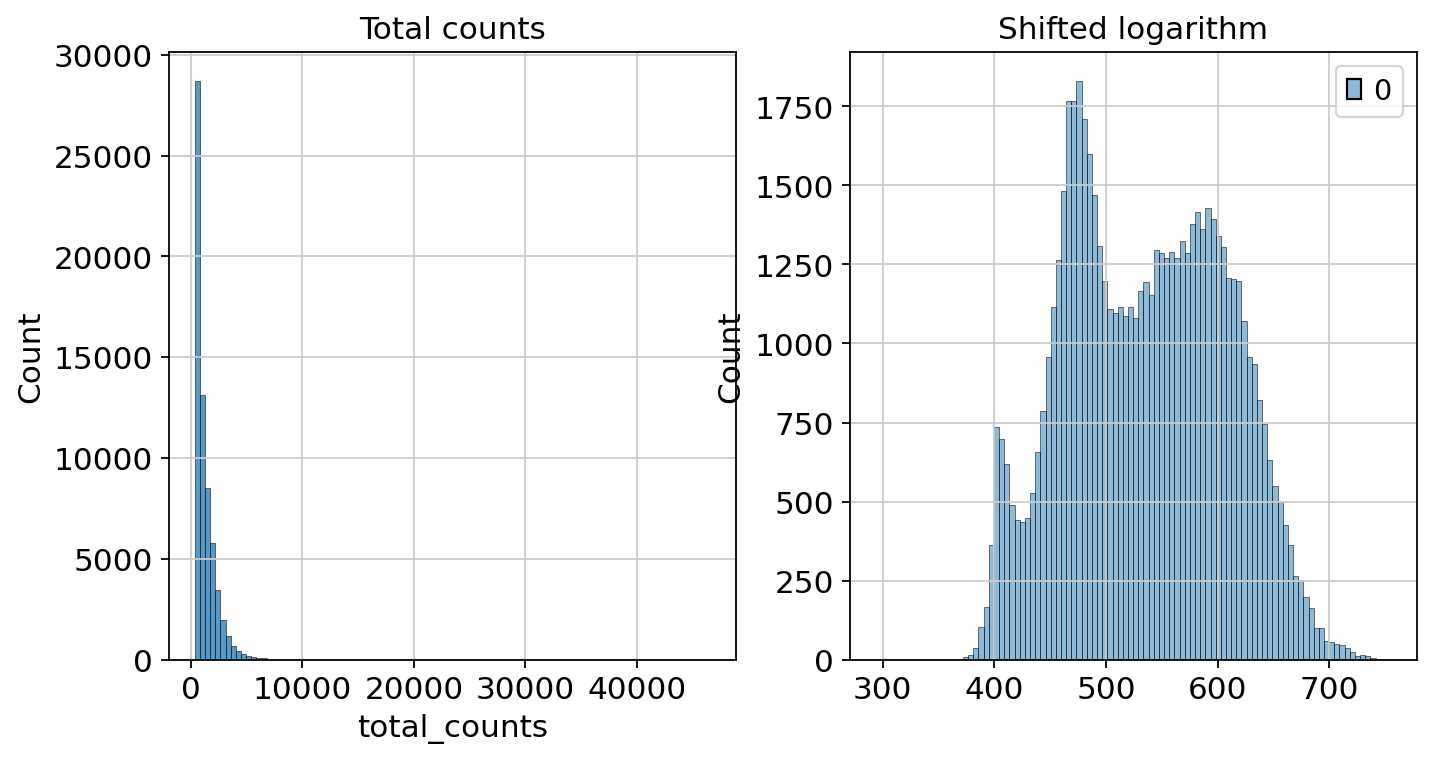

<Figure size 320x320 with 0 Axes>

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot before normalisation
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
plt.savefig(f'{figures}/Jansky_raw.png', bbox_inches='tight')

# Plot after normalisation
p2 = sns.histplot(adata.layers["log1p"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()
plt.savefig(f'{figures}/Jansky_log.png', bbox_inches='tight')

In [33]:
# Save processed file
adata.write(processed_data)

In [19]:
# Run this after saving normalized data
sc.pp.filter_genes(adata, min_cells=3)

filtered out 376 genes that are detected in less than 3 cells


In [32]:
adata

AnnData object with n_obs × n_vars = 64769 × 26344
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'seurat_clusters', 'anno_new', 'CNV', 'celltype', 'patientID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'log1p'